In [35]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy

np.random.seed(42)

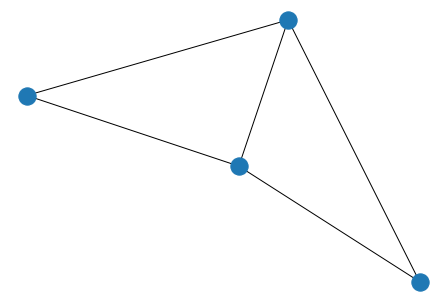

In [36]:
class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)
class Edge:
    def __init__(self, start_node, end_node, weight):
        self.start_node = start_node
        self.end_node = end_node

set_edges = [(0,1,0.5),(1,2,2),(2,0,4.5), (2,3,1.7), (0,3,0.5)] # Define the graph here
G = nx.Graph()
G.add_weighted_edges_from(set_edges)

nx.draw(G)
plt.savefig('graph.png')
# plt.clf() what does this fucntion do? read docs. well not v imp just for ur curiosity
plt.show()

In [27]:
n_wires = 4
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)
ZZPowGate = scipy.linalg.fractional_matrix_power(pauli_z_2, -1*gamma/math.pi)

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        # qml.RX(2 * beta, wires=wire)
        qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]])

# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])
# qml.enable_tape()
# qml.draw(U_C(np.pi))

In [14]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    wires = range(n_wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [15]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [16]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]])) # Change 2

In [34]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero 
    # Array of size (2, n_layers) -> 2 columns 1 for each gamma and beta, then n_layers rows so we have the same num layers as number of beta/gamma elements
    init_params = 0.01 * np.random.rand(2, n_layers) # change 4 -> maxcut unrelated, just so i can have 3 layers.

    # minimize the negative of the objective function
    def objective(params, step):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            weight = edge[2]
            unweighted_obj = 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
            weighted_obj = unweighted_obj * weight
            neg_obj -= weighted_obj # change 3
            if (step + 1) % 20 == 0:
                print(f'Edge: {edge} Unweighted: {unweighted_obj}')
                print(f'Weighted: {weighted_obj}')

            
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.GradientDescentOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 100
    for i in range(steps):
        params = opt.step(objective, params, step=i)
        if (i + 1) % 20 == 0:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, objective(params, step=i)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 1000
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
# bitstrings1 = qaoa_maxcut(n_layers=1)[1]
# bitstrings2 = qaoa_maxcut(n_layers=2)[1]
# bitstrings3 = qaoa_maxcut(n_layers=3)[1]
# bitstrings7 = qaoa_maxcut(n_layers=7)[1]
# bitstrings8 = qaoa_maxcut(n_layers=8)[1]
bitstrings14 = qaoa_maxcut(n_layers=14)
bitstrings15 = qaoa_maxcut(n_layers=15)


p=14
Edge: (0, 1, 0.5) Unweighted: Autograd ArrayBox with value 0.7510175032134643
Weighted: Autograd ArrayBox with value 0.37550875160673214
Edge: (1, 2, 2) Unweighted: Autograd ArrayBox with value 0.751017503213464
Weighted: Autograd ArrayBox with value 1.502035006426928
Edge: (2, 0, 4.5) Unweighted: Autograd ArrayBox with value 0.21128116223252613
Weighted: Autograd ArrayBox with value 0.9507652300463676
Edge: (2, 3, 1.7) Unweighted: Autograd ArrayBox with value 0.7510175032134642
Weighted: Autograd ArrayBox with value 1.2767297554628891
Edge: (0, 3, 0.5) Unweighted: Autograd ArrayBox with value 0.751017503213464
Weighted: Autograd ArrayBox with value 0.375508751606732
Edge: (0, 1, 0.5) Unweighted: 0.3610231633515626
Weighted: 0.1805115816757813
Edge: (1, 2, 2) Unweighted: 0.3610231633515626
Weighted: 0.7220463267031252
Edge: (2, 0, 4.5) Unweighted: 0.4564456235778057
Weighted: 2.0540053061001258
Edge: (2, 3, 1.7) Unweighted: 0.36102316335156254
Weighted: 0.6137393776976563
Edge: (

TypeError: objective() missing 1 required positional argument: 'step'

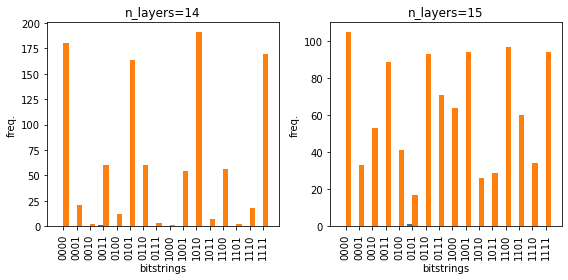

In [32]:
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=14")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings14, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=15")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings15, bins=bins)
plt.tight_layout()
plt.show()

In [30]:
# This was inspired by the Pennylane demo of the maxcut QAOA implementation
import cirq

ModuleNotFoundError: No module named 'cirq'